In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import CCA
from sklearn.manifold import Isomap
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, LinearRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import seaborn as sns
from tqdm.auto import tqdm
import os
import umap
from scipy import linalg
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import accuracy_score

from pyaldata import *

#Import function to get the covariate matrix that includes spike history from previous bins
from Neural_Decoding.preprocessing_funcs import get_spikes_with_history

#Import metrics
from Neural_Decoding.metrics import get_R2
from Neural_Decoding.metrics import get_rho

# import decoder
from Neural_Decoding.decoders import XGBoostDecoder

from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold

In [4]:
data_dir = "/Users/mirej/OneDrive - Imperial College London/imperial/YEAR 3/UROP"
fname = os.path.join(data_dir, "Chewie_CO_CS_2016-10-21.mat")
data = mat2dataframe(fname, shift_idx_fields=True) # Load a trial_data .mat file and turn it into a pandas DataFrame
data.head(n=3) # print in a table; head(n=3) means only print the first 5 rows

,monkey,date,task,target_direction,trial_id,result,bin_size,perturbation,perturbation_info,epoch,...,idx_peak_speed,idx_trial_end,pos,vel,acc,force,M1_spikes,M1_unit_guide,PMd_spikes,PMd_unit_guide
0,Chewie,10-21-2016,CO,0.785398,1,R,0.01,CS,-0.52,BL,...,369,446,"[[5.778064202616431, -35.397015549165786], [5....","[[-0.7793813732066821, 4.136785603960551], [-1...","[[-51.969786428074926, 14.202847093285325], [-...","[[0.12316992347195488, 0.2506054987408934], [0...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,...","[[1, 1], [1, 2], [3, 1], [5, 1], [5, 2], [7, 1...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1], [1, 2], [1, 3], [4, 1], [4, 2], [5, 1..."
1,Chewie,10-21-2016,CO,1.570796,2,R,0.01,CS,-0.52,BL,...,312,374,"[[5.749738457404149, -24.643406091404042], [5....","[[1.9163909188240478, -2.763349295373866], [1....","[[-36.779409320972285, 1.7821809867372298], [-...","[[0.3685575721810173, 0.17911060954700603], [0...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1], [1, 2], [3, 1], [5, 1], [5, 2], [7, 1...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1], [1, 2], [1, 3], [4, 1], [4, 2], [5, 1..."
2,Chewie,10-21-2016,CO,-1.570796,3,R,0.01,CS,-0.52,BL,...,341,405,"[[-0.08846028882207335, -21.796383214740942], ...","[[0.6600912719115256, -4.014682191879345], [0....","[[15.812499710917256, 16.621785484272777], [10...","[[0.3523246575179767, -0.09122904723894733], [...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...","[[1, 1], [1, 2], [3, 1], [5, 1], [5, 2], [7, 1...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[1, 1], [1, 2], [1, 3], [4, 1], [4, 2], [5, 1..."


In [5]:
#preprocessing of the data
td = combine_time_bins(data, 2) #get 20 ms bins
td = remove_low_firing_neurons(td, "M1_spikes", 5)
td = remove_low_firing_neurons(td, "PMd_spikes", 5)
td = transform_signal(td, "M1_spikes",  'sqrt')
td = transform_signal(td, "PMd_spikes", 'sqrt')
td = merge_signals(td, ["M1_spikes", "PMd_spikes"], "both_spikes")
td = add_firing_rates(td, 'smooth') 

c:\users\mirej\onedrive - imperial college london\documents\python stuff\pyaldata\pyaldata\tools.py:938: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")
c:\users\mirej\onedrive - imperial college london\documents\python stuff\pyaldata\pyaldata\tools.py:938: UserWarning: Assuming spikes are actually spikes and dividing by bin size.
  utils.warnings.warn("Assuming spikes are actually spikes and dividing by bin size.")


In [6]:
def get_target_id(trial):
    return int(np.round((trial.target_direction + np.pi) / (0.25 * np.pi))) - 1

td["target_id"] = td.apply(get_target_id, axis=1)
targets = td.target_id.unique()
targets.sort(axis=0)  # ascending order

td = select_trials(td, "result == 'R'")
move_td = restrict_to_interval(td, "idx_movement_on", end_point_name=None, before=30, after=30)
move_td = subtract_cross_condition_mean(move_td)

pca_dims = 60
move_td = dim_reduce(move_td, PCA(pca_dims), "both_rates", "both_pca")

c:\users\mirej\onedrive - imperial college london\documents\python stuff\pyaldata\pyaldata\tools.py:592: UserWarning: 'before' is deprecated. Use 'rel_start' instead.
  warnings.warn("'before' is deprecated. Use 'rel_start' instead.")
c:\users\mirej\onedrive - imperial college london\documents\python stuff\pyaldata\pyaldata\tools.py:595: UserWarning: 'after' is deprecated. Use 'rel_end' instead.
  warnings.warn("'after' is deprecated. Use 'rel_end' instead.")


In [191]:
# we preform UMAP

move_td = dim_reduce(move_td, umap.UMAP(n_neighbors=30,min_dist=0.3, n_components=10), "both_rates", "both_umap")

In [192]:
av_per_dir = trial_average(move_td, "target_id")

In [7]:
# we preform ISOMAP
n_components = 10
n_neighbours = 30
move_td = dim_reduce(move_td, Isomap(n_neighbours, n_components), "both_rates", "both_isomap")
av_per_dir2 = trial_average(move_td, "target_id")


C:\Users\mirej\anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_neighbors=30, n_components=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [13]:
av_per_dir2.both_isomap.values[0]

array([[-7.83729563e+01,  4.39081797e+01, -3.57859537e+00,
        -7.39177938e+01,  2.84604925e+01, -2.53500933e+01,
        -1.38396242e+01, -1.03081851e+01,  2.80782528e+01,
        -2.16884425e+01],
       [-8.03102227e+01,  4.46095272e+01, -5.45527605e+00,
        -7.44426406e+01,  3.08308963e+01, -2.67920210e+01,
        -1.48181896e+01, -1.02233039e+01,  2.66705941e+01,
        -2.28624206e+01],
       [-8.53115296e+01,  4.65752196e+01, -8.12835563e+00,
        -7.51718439e+01,  3.31914899e+01, -2.78669715e+01,
        -1.55403786e+01, -1.15064554e+01,  2.58976744e+01,
        -2.63767963e+01],
       [-8.92076017e+01,  4.95533106e+01, -1.00640824e+01,
        -7.63492818e+01,  3.39539029e+01, -2.90100143e+01,
        -1.37464698e+01, -1.27459261e+01,  2.36108062e+01,
        -2.85442651e+01],
       [-9.16323906e+01,  5.11242647e+01, -1.25733011e+01,
        -7.77505034e+01,  3.33324687e+01, -3.12768951e+01,
        -1.30506146e+01, -1.22761158e+01,  2.19535144e+01,
        -2.

In [11]:
#cca = CCA(n_components=2)
#av_per_dir = trial_average(move_td, "target_id")
#whole_signal = utils.concat_trials(av_per_dir, "both_umap")
whole_signal2 =utils.concat_trials(av_per_dir2, "both_isomap")
#q = cca.fit(whole_signal, whole_signal2)
#av_per_dir.both_umap.values[0]
#X, Y = cca.transform(whole_signal, whole_signal2)

#av_per_dir.both_umap.values[0].shape
whole_signal2.shape[0]

488

In [136]:
#check correlation between the cannonical covariates
#np.corrcoef(X[:, 1], Y[:, 1])
av_per_dir.head()
X = av_per_dir.both_isomap.values
X

array([array([[-7.83729563e+01,  4.39081797e+01, -3.57859537e+00,
               -7.39177938e+01,  2.84604925e+01, -2.53500933e+01,
               -1.38396242e+01, -1.03081851e+01,  2.80782528e+01,
               -2.16884425e+01],
              [-8.03102227e+01,  4.46095272e+01, -5.45527605e+00,
               -7.44426406e+01,  3.08308963e+01, -2.67920210e+01,
               -1.48181896e+01, -1.02233039e+01,  2.66705941e+01,
               -2.28624206e+01],
              [-8.53115296e+01,  4.65752196e+01, -8.12835563e+00,
               -7.51718439e+01,  3.31914899e+01, -2.78669715e+01,
               -1.55403786e+01, -1.15064554e+01,  2.58976744e+01,
               -2.63767963e+01],
              [-8.92076017e+01,  4.95533106e+01, -1.00640824e+01,
               -7.63492818e+01,  3.39539029e+01, -2.90100143e+01,
               -1.37464698e+01, -1.27459261e+01,  2.36108062e+01,
               -2.85442651e+01],
              [-9.16323906e+01,  5.11242647e+01, -1.25733011e+01,
          

In [ ]:
plt.figure(figsize=(5,4))
plt.scatter(X[:, 1], Y[:, 1])

In [10]:
plt.figure(figsize=(5,4))
plt.scatter(X[:, 0], Y[:, 0])

NameError: name 'X' is not defined

<Figure size 360x288 with 0 Axes>

In [196]:
def canoncorr(X:np.array, Y: np.array, fullReturn: bool = False) -> np.array:
    """
    Canonical Correlation Analysis (CCA)
    line-by-line port from Matlab implementation of `canoncorr`
    X,Y: (samples/observations) x (features) matrix, for both: X.shape[0] >> X.shape[1]
    fullReturn: whether all outputs should be returned or just `r` be returned (not in Matlab)
    
    returns: A,B,r,U,V 
    A,B: Canonical coefficients for X and Y
    U,V: Canonical scores for the variables X and Y
    r:   Canonical correlations
    
    Signature:
    A,B,r,U,V = canoncorr(X, Y)
    """
    n, p1 = X.shape
    p2 = Y.shape[1]
    if p1 >= n or p2 >= n:
        logging.warning('Not enough samples, might cause problems')

    # Center the variables
    X = X - np.mean(X,0)
    Y = Y - np.mean(Y,0)

    # Factor the inputs, and find a full rank set of columns if necessary
    Q1,T11,perm1 = linalg.qr(X, mode='economic', pivoting=True, check_finite=True)

    rankX = sum(np.abs(np.diagonal(T11)) > np.finfo(type((np.abs(T11[0,0])))).eps*max([n,p1]));

    if rankX == 0:
        logging.error(f'stats:canoncorr:BadData = X')
    elif rankX < p1:
        logging.warning('stats:canoncorr:NotFullRank = X')
        Q1 = Q1[:,:rankX]
        T11 = T11[rankX,:rankX]

    Q2,T22,perm2 = linalg.qr(Y, mode='economic', pivoting=True, check_finite=True)
    rankY = sum(np.abs(np.diagonal(T22)) > np.finfo(type((np.abs(T22[0,0])))).eps*max([n,p2]));

    if rankY == 0:
        logging.error(f'stats:canoncorr:BadData = Y')
    elif rankY < p2:
        logging.warning('stats:canoncorr:NotFullRank = Y')
        Q2 = Q2[:,:rankY];
        T22 = T22[:rankY,:rankY];

    # Compute canonical coefficients and canonical correlations.  For rankX >
    # rankY, the economy-size version ignores the extra columns in L and rows
    # in D. For rankX < rankY, need to ignore extra columns in M and D
    # explicitly. Normalize A and B to give U and V unit variance.
    d = min(rankX,rankY);
    L,D,M = linalg.svd(Q1.T @ Q2, full_matrices=True, check_finite=True, lapack_driver='gesdd')
    M = M.T

    A = linalg.inv(T11) @ L[:,:d] * np.sqrt(n-1);
    B = linalg.inv(T22) @ M[:,:d] * np.sqrt(n-1);
    r = D[:d]
    # remove roundoff errs
    r[r>=1] = 1
    r[r<=0] = 0

    if not fullReturn:
        return r

    # Put coefficients back to their full size and their correct order
    A[perm1,:] = np.vstack((A, np.zeros((p1-rankX,d))))
    B[perm2,:] = np.vstack((B, np.zeros((p2-rankY,d))))
    
    # Compute the canonical variates
    U = X @ A
    V = Y @ B

    return A, B, r, U, V 


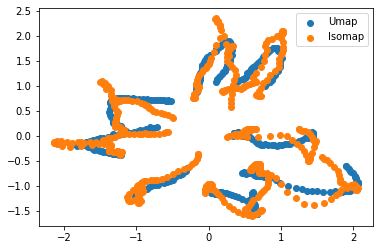

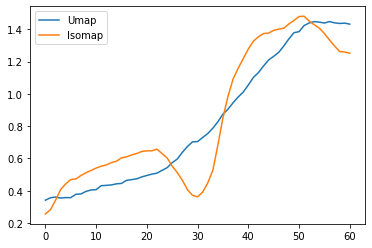

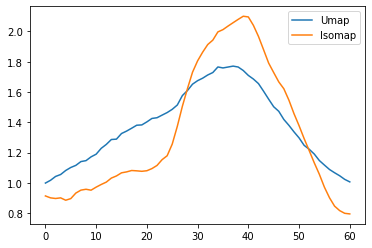

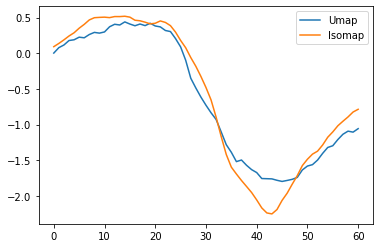

(488, 10)

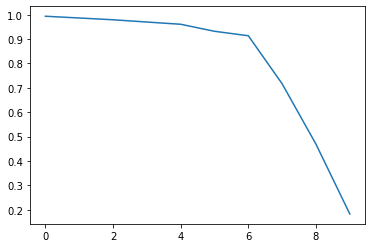

In [198]:
A, B, r, U, V = canoncorr(whole_signal, whole_signal2, fullReturn = True)
plt.scatter(U[:,0], U[:,1])
plt.scatter(V[:,0], V[:,1])
plt.legend(['Umap', 'Isomap']);
plt.show()
# plot the cc againts time and then r plot against CCs
tsteps = av_per_dir.both_isomap.values[0].shape[0]
for i in range(3):
    plt.plot(U[i*tsteps:(i+1)*tsteps,i])
    plt.plot(V[i*tsteps:(i+1)*tsteps,i])
    plt.legend(['Umap', 'Isomap'])
    plt.show()
A
plt.show()
# plt.scatter(t, B)
plt.plot(r)
U.shape[1]
tsteps
U.shape
# reconstructing data from PCA (multypling latent activity by the eigenvectors) - see error between reconcuntratopn data and real data

In [139]:
def get_classif_cv_scores_through_time(td, classif_class, input_field, field_to_predict, cv=10, model_kwargs=None, progress_bar=True, n_jobs=None):
    if model_kwargs is None:
        model_kwargs = {}
    T = td[input_field].values[0].shape[0]
    scores = []
    for t in tqdm(np.arange(T), disable=not progress_bar):
        X = np.stack([arr[t, :] for arr in td[input_field]])
        y = td[field_to_predict].values
        scores.append(cross_val_score(classif_class(**model_kwargs),
                                      X, y,
                                      cv=cv,
                                      scoring=make_scorer(accuracy_score),
                                      n_jobs = n_jobs))
    return np.stack(scores)
 
def plot_cv_scores_through_time(scores, ax=None, **plot_kwargs):
    if ax is None:
        fig, ax = plt.subplots()
    mean_cv_score = np.mean(scores, axis=1)
    var_cv_score = np.var(scores, axis=1)
    a = ax.plot(mean_cv_score, **plot_kwargs)
    ax.fill_between(np.arange(len(mean_cv_score)), mean_cv_score - var_cv_score, mean_cv_score + var_cv_score, alpha = 0.1)
    return a

  0%|          | 0/61 [00:00<?, ?it/s]

C:\Users\mirej\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mirej\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mirej\anaconda3\lib\site-packages\sklearn\linear_model\_base.py", line 518, in fit
    X, y = self._validate_data(X, y, accept_sparse=accept_sparse,
  File "C:\Users\mirej\anaconda3\lib\site-packages\sklearn\base.py", line 433, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\mirej\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\mirej\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 823, in check_X_y
    y = check_array(y, accept_sparse=

C:\Users\mirej\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mirej\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mirej\anaconda3\lib\site-packages\sklearn\linear_model\_base.py", line 518, in fit
    X, y = self._validate_data(X, y, accept_sparse=accept_sparse,
  File "C:\Users\mirej\anaconda3\lib\site-packages\sklearn\base.py", line 433, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\mirej\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\mirej\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 823, in check_X_y
    y = check_array(y, accept_sparse=

C:\Users\mirej\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mirej\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mirej\anaconda3\lib\site-packages\sklearn\linear_model\_base.py", line 518, in fit
    X, y = self._validate_data(X, y, accept_sparse=accept_sparse,
  File "C:\Users\mirej\anaconda3\lib\site-packages\sklearn\base.py", line 433, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\mirej\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\mirej\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 823, in check_X_y
    y = check_array(y, accept_sparse=

C:\Users\mirej\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\mirej\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mirej\anaconda3\lib\site-packages\sklearn\linear_model\_base.py", line 518, in fit
    X, y = self._validate_data(X, y, accept_sparse=accept_sparse,
  File "C:\Users\mirej\anaconda3\lib\site-packages\sklearn\base.py", line 433, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\Users\mirej\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\mirej\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 823, in check_X_y
    y = check_array(y, accept_sparse=

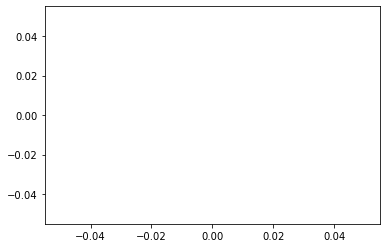

In [140]:
s = get_classif_cv_scores_through_time(p, LinearRegression,"both_isomap","vel", cv=10, model_kwargs=None, progress_bar=True, n_jobs=None)
plot_cv_scores_through_time(s)

In [201]:
# try XGBoost as non linear way to decode with ISOMAP
#bins_before=6 #How many bins of neural data prior to the output are used for decoding
#bins_current=1 #Whether to use concurrent time bin of neural data
#bins_after=6 #How many bins of neural data after the output are used for decoding
#X=get_spikes_with_history(av_per_dir2.both_isomap.values,bins_before,bins_after,bins_current)
#X_flat=X.reshape(X.shape[0],(X.shape[1]*X.shape[2]))
model_xgb=XGBoostDecoder(max_depth=3,num_round=200,eta=0.3,gpu=-1) 

X_flat = utils.concat_trials(move_td, "both_isomap")
y_flat = utils.concat_trials(move_td, "vel")
    

num_examples = 8 * av_per_dir2.both_isomap.values[0].shape[0]
num_examples
X_flat.shape

(17446, 10)

In [150]:
#separate into training and testing data
bins_before=6 #How many bins of neural data prior to the output are used for decoding
bins_current=1 #Whether to use concurrent time bin of neural data
bins_after=6 #How many bins of neural data after the output are used for decoding
training_range=[0, 0.7]
testing_range=[0.7, 0.85]
valid_range=[0.85,1]

training_set=np.arange(np.int(np.round(training_range[0]*num_examples))+bins_before,np.int(np.round(training_range[1]*num_examples))-bins_after)
testing_set=np.arange(np.int(np.round(testing_range[0]*num_examples))+bins_before,np.int(np.round(testing_range[1]*num_examples))-bins_after)
valid_set=np.arange(np.int(np.round(valid_range[0]*num_examples))+bins_before,np.int(np.round(valid_range[1]*num_examples))-bins_after)
X_flat
#whole_signal
# I don't really get why we use this parameters and not different ones?
#av_per_dir.vel.values
#training_set

<ipython-input-150-4686b47f42ad>:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  training_set=np.arange(np.int(np.round(training_range[0]*num_examples))+bins_before,np.int(np.round(training_range[1]*num_examples))-bins_after)
<ipython-input-150-4686b47f42ad>:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to

array([[  60.820876  ,  -47.94575831,   96.53295526, ...,  -14.01402785,
           1.21172742,  -53.55847533],
       [  56.13055231,  -58.01657518,   86.10315382, ...,  -16.24055977,
         -20.60624947,  -59.79580157],
       [  47.17136158,  -60.7926953 ,   78.44354122, ...,  -26.38914032,
         -41.2315582 ,  -62.64750396],
       ...,
       [ -97.9948245 ,   58.53832976,   -9.88136617, ...,  -96.25216059,
          25.31110315,  -59.62412138],
       [ -91.85133487,   55.62668499,   -2.45304537, ...,  -99.05929738,
          18.22487209,  -55.59054624],
       [ -83.12203154,   50.14273863,   12.7340319 , ..., -101.09492175,
           9.53101956,  -49.5695048 ]])

In [151]:
#Get training data

X_flat_train=X_flat[training_set,:]
X_flat_valid=X_flat[valid_set,:]

# I also flat y (they don't do it) pyaldata does it with linear regression
y_train=y_flat[training_set,:] 
y_valid=y_flat[valid_set,:]

In [144]:
#if we want to z-score x and y - it gives very weird answers??
X_flat_train_mean=np.nanmean(X_flat_train,axis=0)
X_flat_train_std=np.nanstd(X_flat_train,axis=0)
X_flat_train=(X_flat_train-X_flat_train_mean)/X_flat_train_std

y_train_mean=np.mean(y_train,axis=0)
y_train=y_train-y_train_mean
y_valid=y_valid-y_train_mean

In [200]:
#Declare model
model_xgb=XGBoostDecoder(max_depth=3,num_round=200,eta=0.3,gpu=-1) 

#Fit model
model_xgb.fit(X_flat_train, y_train)

#Get predictions
y_valid_predicted_xgb=model_xgb.predict(X_flat_valid)

#Get metric of fit
R2s_xgb=get_R2(y_valid,y_valid_predicted_xgb)
print('R2s:', R2s_xgb)

[16:23:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[16:23:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




C:\Users\mirej\anaconda3\lib\site-packages\xgboost\data.py:119: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


XGBoostError: [16:23:40] C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/data/data.cc:583: Check failed: labels_.Size() == num_row_ (11688 vs. 330) : Size of labels must equal to number of rows.

In [202]:
# another way of doing XGBoost
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_flat, y_flat, test_size=0.33, random_state=7)
#model = XGBClassifier()
#model.fit(X_train, y_train)
model_xgb.fit(X_train, y_train)
# make predictions for test data
y_pred = model_xgb.predict(X_test)

R2s_xgb=get_R2(y_test,y_pred)
print('R2s:', R2s_xgb)


C:\Users\mirej\anaconda3\lib\site-packages\xgboost\data.py:119: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[16:24:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[16:24:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




C:\Users\mirej\anaconda3\lib\site-packages\xgboost\data.py:119: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[16:24:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[16:24:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


R2s: [0.88280232 0.90148585]


In [204]:
# PCA
X_flat = utils.concat_trials(move_td, "both_umap")
y_flat = utils.concat_trials(move_td, "vel")

X_train, X_test, y_train, y_test = train_test_split(X_flat, y_flat, test_size=0.33, random_state=7)
#model = XGBClassifier()
#model.fit(X_train, y_train)
model_xgb.fit(X_train, y_train)
# make predictions for test data
y_pred = model_xgb.predict(X_test)

R2s_xgb=get_R2(y_test,y_pred)
print('R2s:', R2s_xgb)


C:\Users\mirej\anaconda3\lib\site-packages\xgboost\data.py:119: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:29:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[17:29:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




C:\Users\mirej\anaconda3\lib\site-packages\xgboost\data.py:119: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


[17:29:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[17:29:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


R2s: [0.93522413 0.93694579]
